In [1]:
import sys
sys.path.append('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/raygun/CycleGAN/')
from CycleGun_CBxFN90nmtile3_CBx30nmBottom100um_20210925_ import *
import matplotlib.pyplot as plt
import zarr


Importing dependencies...
Loading model...
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal


In [2]:
cycleGun.set_device(3)

INFO:gunpowder.torch.nodes.train:Resuming training from iteration 60000
INFO:gunpowder.torch.nodes.train:Loading /n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/raygun/CycleGAN/models/CycleGun_CBxFN90nmtile3_CBx30nmBottom100um_20210925_checkpoint_60000
INFO:gunpowder.torch.nodes.train:Using device cuda
INFO:gunpowder.nodes.generic_train:Train process: iteration=60001 loss=5.536637 time=1.462137


{'loss_D1': 0.10715159773826599, 'loss_D2': 0.038601335138082504, 'loss_cycle': 0.929395318031311, 'loss_G1': 2.2743825912475586, 'loss_G2': 2.187106132507324}


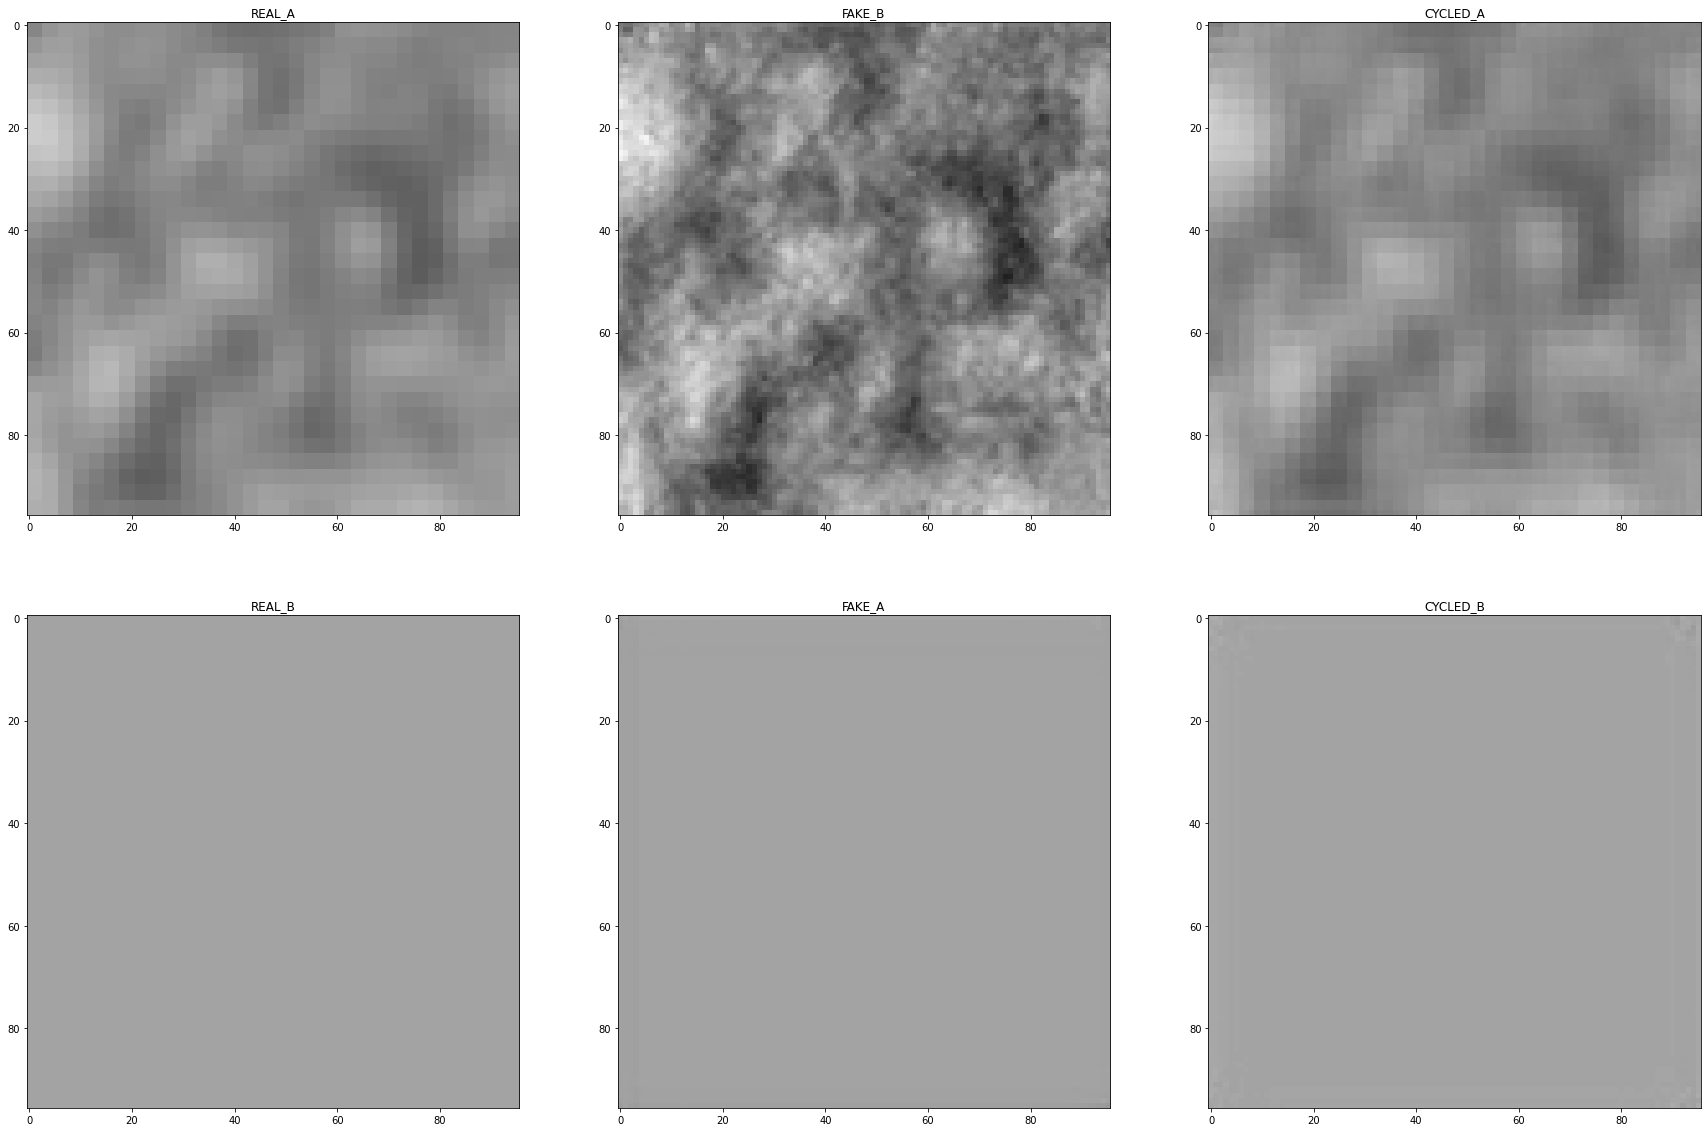

In [5]:
batch = cycleGun.test_train()

In [7]:
batch


	REAL_A: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: True, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	FAKE_A: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: None, placeholder: False
	CYCLED_A: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: None, placeholder: False
	REAL_B: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: True, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	FAKE_B: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: None, placeholder: False
	CYCLED_B: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: None, placeholder: False

INFO:gunpowder.torch.nodes.predict:Predicting on gpu


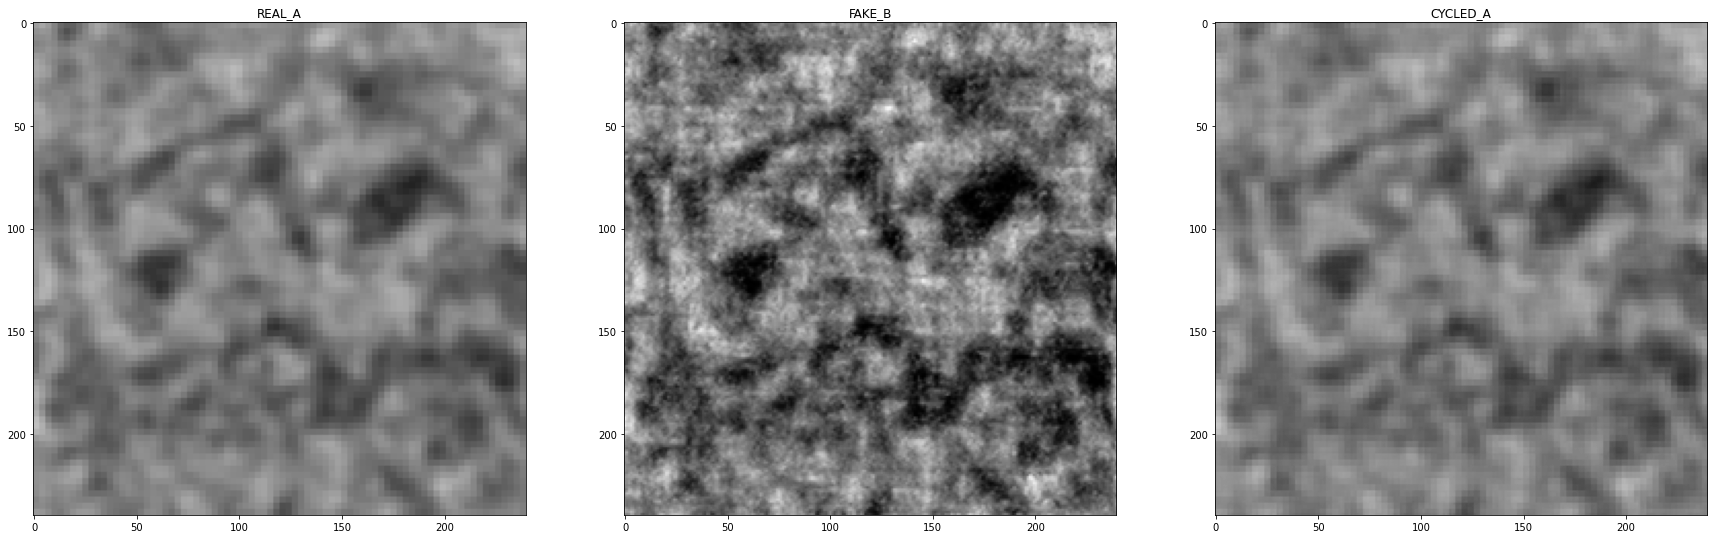

In [4]:
pred_batch = cycleGun.test_prediction('A', side_length=80) #80 biggest succesful on RTX-2080

In [4]:
pred_batch


	REAL_A: ROI: [0:7200, 0:7200, 0:7200] (7200, 7200, 7200), voxel size: (30, 30, 30), interpolatable: True, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	FAKE_B: ROI: [0:7200, 0:7200, 0:7200] (7200, 7200, 7200), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: None, placeholder: False
	CYCLED_A: ROI: [0:7200, 0:7200, 0:7200] (7200, 7200, 7200), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: None, placeholder: False

In [2]:
cycleGun.render_full()

Full rendering pipeline declared for input type A. Building...
Starting full volume render...


INFO:gunpowder.nodes.scan:scanning over 1030301 chunks
INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.torch.nodes.predict:Predicting on gpu
ERROR:gunpowder.producer_pool:Exception in ZarrWrite while processing request
	REAL_A: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	FAKE_B: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	CYCLED_A: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: None, non-spatial: False, dtype: None, placeholder: False
 
Batch returned so far:
None
Traceback (most recent call last):
  File "/mnt/orchestra_nfs/users/jlr54/envs/miniconda3/envs/n2v/lib/python3.7/site-packages/gunpowder/torch/nodes/predict.py", line 100, in start
    self.model = s

In [4]:
for array, value in cycleGun.batch.items():
    print(value.data.shape)

(96, 96, 96)
(96, 96, 96)
(96, 96, 96)
(96, 96, 96)
(96, 96, 96)
(96, 96, 96)


In [2]:
cycleGun.build_training_pipeline()
req = gp.BatchRequest()
req.add(cycleGun.real_A, cycleGun.voxel_size*cycleGun.context_side_length*cycleGun.AB_voxel_ratio)
# req.add(cycleGun.real_A_cropped, cycleGun.voxel_size*cycleGun.side_length*cycleGun.AB_voxel_ratio)
with gp.build(cycleGun.pipe_A):
    batch = cycleGun.pipe_A.request_batch(req)
batch.arrays
real_A = torch.as_tensor(batch[cycleGun.real_A].data).cuda(1)

In [3]:
cycleGun.netG1.cuda(1)

Sequential(
  (0): UNet(
    (l_conv): ModuleList(
      (0): ConvPass(
        (conv_pass): Sequential(
          (0): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): ReLU()
          (2): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): ReLU()
        )
      )
      (1): ConvPass(
        (conv_pass): Sequential(
          (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): ReLU()
          (2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): ReLU()
        )
      )
      (2): ConvPass(
        (conv_pass): Sequential(
          (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): ReLU()
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): ReLU()
        )
      )
    )
    (l_down): ModuleList(
      (0): Downsample(
        (down):

In [5]:
fake_B = cycleGun.netG1(real_A)
fake_B.shape

torch.Size([1, 1, 96, 96, 96])

In [6]:
real_A.shape

torch.Size([1, 1, 96, 96, 96])

In [47]:
cycleGun.side_length * cycleGun.AB_voxel_ratio
# 2880 /30
188 / 30

6.266666666666667

In [45]:
cycleGun.context_side_length - cycleGun.side_length

44

In [33]:
fake_B.shape

torch.Size([1, 1, 188, 188, 188])

In [6]:
z = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/raygun/CycleGAN/snapshots/00000075.zarr')
im = np.array(z['B']['raw']).squeeze()
z.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,2
No. arrays,0
No. groups,2
Groups,"A, B"


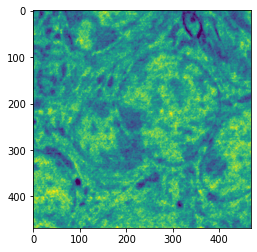

In [7]:
plt.imshow(im[234,...])

In [2]:
import zarr
import numpy as np
import matplotlib.pyplot as plt

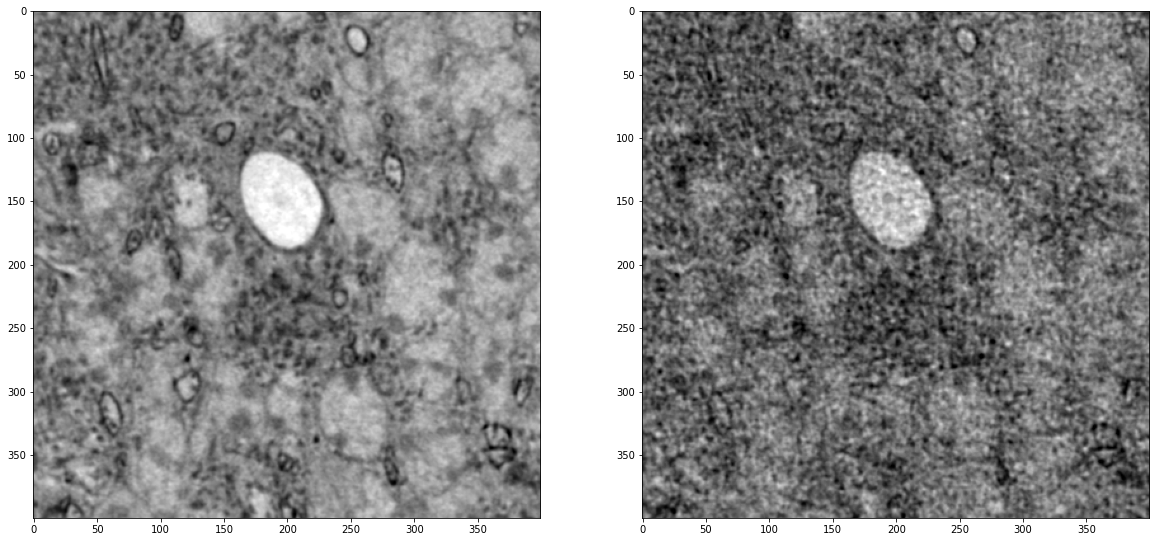

In [27]:
z = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBm_FN_lobX_90nm_tile2_rec_db9_twopass_full_.n5')
y = zarr.open('/n/groups/htem/ESRF_id16a/LTP/cb_FN_lobX_feb2021/volraw/CBm_FN_lobX_90nm_tile2_rec_db9_twopass_full_.n5')

full = np.array(z['volumes']['raw'][1400:1800, 1400:1800, 1400:1800]).squeeze()
quart = np.array(z['volumes']['quarterAngle'][1400:1800, 1400:1800, 1400:1800]).squeeze()
# quart = np.array(z['volumes']['quarterAngle'][1400:1800, 1400:1800, 1400:1800]).squeeze()
# z['volumes']['quarterAngle'].info
# y['volumes']['raw'].info

fig, ax = plt.subplots(1, 2, figsize=(20,40))
ax[0].imshow(full[200,...], cmap='gray')
ax[1].imshow(quart[200,...], cmap='gray')

In [22]:
(quart == full).all()

True

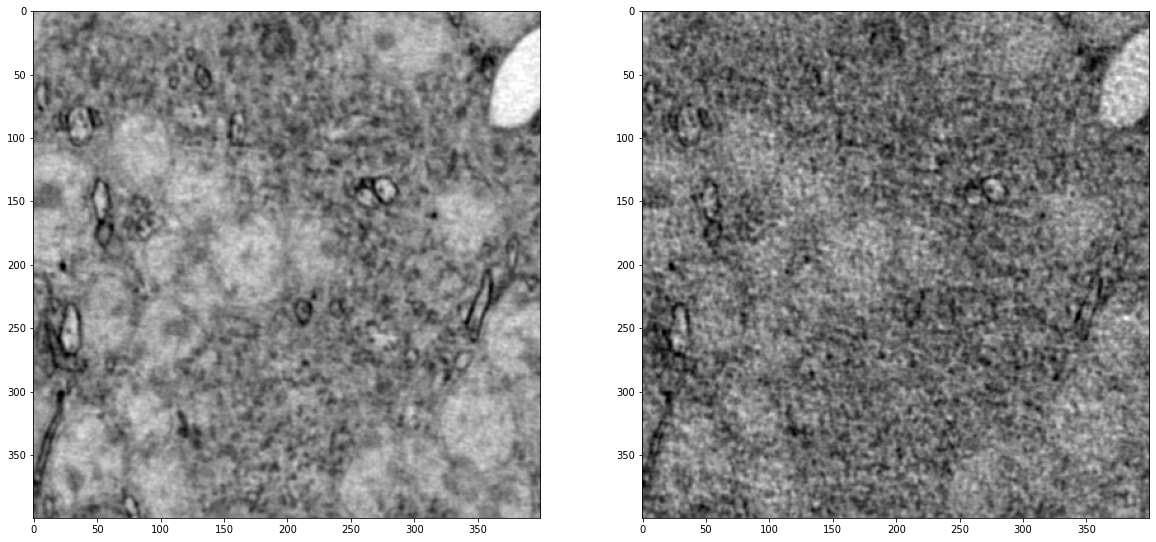

In [23]:
z = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBm_FN_lobX_90nm_tile3_twopass_rec_.n5')
y = zarr.open('/n/groups/htem/ESRF_id16a/LTP/cb_FN_lobX_feb2021/volraw/CBm_FN_lobX_90nm_tile3_twopass_rec_.n5')

full = np.array(z['volumes']['raw'][1400:1800, 1400:1800, 1400:1800]).squeeze()
quart = np.array(z['volumes']['quarterAngle'][1400:1800, 1400:1800, 1400:1800]).squeeze()
# quart = np.array(z['volumes']['quarterAngle'][1400:1800, 1400:1800, 1400:1800]).squeeze()
# z['volumes']['quarterAngle'].info
# y['volumes']['raw'].info

fig, ax = plt.subplots(1, 2, figsize=(20,40))
ax[0].imshow(full[200,...], cmap='gray')
ax[1].imshow(quart[200,...], cmap='gray')

In [39]:
z['volumes']['quarterAngle'].attrs.keys()

dict_keys(['offset', 'resolution'])

In [23]:
z = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBxs_lobX_bottomp100um_30nm_rec_db9_.n5')
im = np.array(z['volumes']['raw'][1400:1800, 1400:1800, 1024]).squeeze()
z['volumes']['raw'].info

Name,/volumes/raw
Type,zarr.core.Array
Data type,uint8
Shape,"(3216, 3216, 2048)"
Chunk shape,"(201, 201, 128)"
Order,C
Read-only,False
Compressor,"N5ChunkWrapper(chunk_shape=(201, 201, 128), compressor_config={'id': 'gzip', 'level': 5}, dtype=dtype('uint8'))"
Store type,zarr.n5.N5Store
No. bytes,21181759488 (19.7G)
No. bytes stored,373


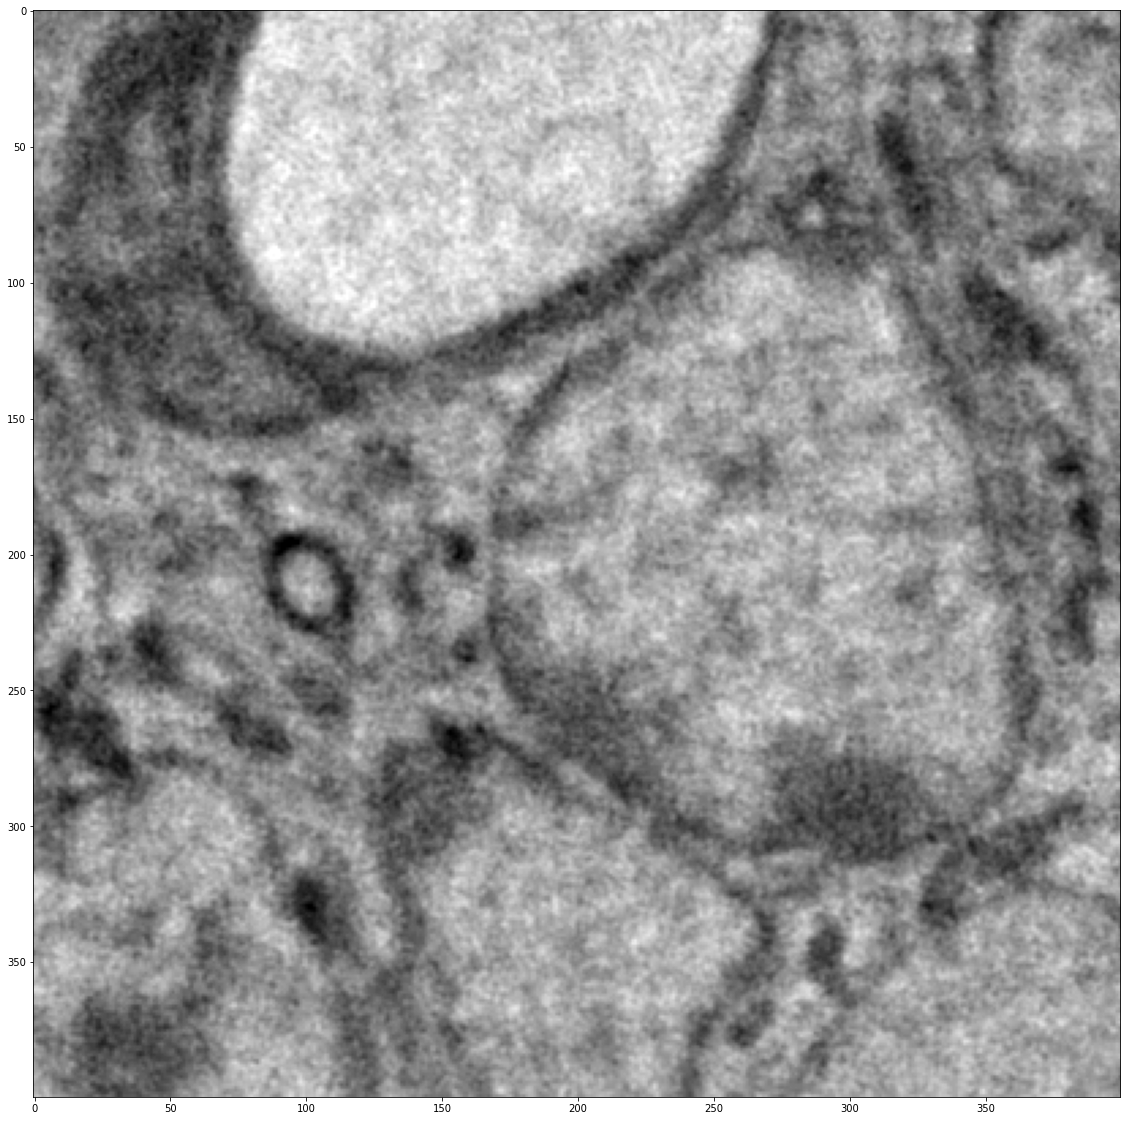

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(im, cmap='gray')